In [135]:
# import all relevant libraries
import pandas as pd
import numpy as np
import uuid
import re
import json
from pandas.plotting import register_matplotlib_converters
from pandas import json_normalize
import matplotlib.pyplot as plt



In [136]:
charging = pd.read_csv("charging_sessions.csv", encoding = "ISO-8859-1")

In [137]:
charging.head()

,Unnamed: 0,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [138]:
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        66450 non-null  int64  
 1   id                66450 non-null  object 
 2   connectionTime    66450 non-null  object 
 3   disconnectTime    66450 non-null  object 
 4   doneChargingTime  62362 non-null  object 
 5   kWhDelivered      66450 non-null  float64
 6   sessionID         66450 non-null  object 
 7   siteID            66450 non-null  int64  
 8   spaceID           66450 non-null  object 
 9   stationID         66450 non-null  object 
 10  timezone          66450 non-null  object 
 11  userID            49187 non-null  float64
 12  userInputs        49187 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 6.6+ MB


In [139]:
charging = charging.drop(columns=['Unnamed: 0']).reset_index(drop=True)

charging['connectionTime'] = pd.to_datetime(charging['connectionTime'])
charging['disconnectTime'] = pd.to_datetime(charging['disconnectTime'])
charging['doneChargingTime'] = pd.to_datetime(charging['doneChargingTime'])

#id sind floats in CSV aber sind alle ints
#null werte zu 0.0 umwandeln
charging['userID'] = charging['userID'].fillna(0.0)
charging['userID'] = charging['userID'].astype(int)

charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                66450 non-null  object             
 1   connectionTime    66450 non-null  datetime64[ns, UTC]
 2   disconnectTime    66450 non-null  datetime64[ns, UTC]
 3   doneChargingTime  62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered      66450 non-null  float64            
 5   sessionID         66450 non-null  object             
 6   siteID            66450 non-null  int64              
 7   spaceID           66450 non-null  object             
 8   stationID         66450 non-null  object             
 9   timezone          66450 non-null  object             
 10  userID            66450 non-null  int32              
 11  userInputs        49187 non-null  object             
dtypes: datetime64[ns, UTC](3), float64(1), int32(1), int64(1), o

In [140]:
def parse_json(x):
    if isinstance(x, str):
        x = x.replace("'", '"').strip()
        x = re.sub(r'\bTrue\b', 'true', x)
        x = re.sub(r'\bFalse\b', 'false', x)    
        try:
            return json.loads(x)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e} | Input: {x}")  # Print error and input
            return []  # Return an empty list if parsing fails
    return []

charging['userInputs'] = charging['userInputs'].apply(parse_json)
user_inputs_expanded = json_normalize(charging['userInputs'].explode()).add_prefix('userInputs_')
charging = charging.drop(columns=['userInputs']).reset_index(drop=True).join(user_inputs_expanded.reset_index(drop=True))

charging['userInputs_userID'] = charging['userID'].astype(int)

charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             66450 non-null  object             
 1   connectionTime                 66450 non-null  datetime64[ns, UTC]
 2   disconnectTime                 66450 non-null  datetime64[ns, UTC]
 3   doneChargingTime               62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   66450 non-null  float64            
 5   sessionID                      66450 non-null  object             
 6   siteID                         66450 non-null  int64              
 7   spaceID                        66450 non-null  object             
 8   stationID                      66450 non-null  object             
 9   timezone                       66450 non-null  object             
 10  userID                

In [141]:
#check if userInputs_userID always equal to userID
# 
charging['userID_matches'] = charging['userID'] == charging['userInputs_userID']
charging['userID_matches'].describe()

count     66450
unique        1
top        True
freq      66450
Name: userID_matches, dtype: object

In [142]:
charging = charging.drop(columns=['userID_matches']).reset_index(drop=True)
charging = charging.drop(columns=['userInputs_userID']).reset_index(drop=True)
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             66450 non-null  object             
 1   connectionTime                 66450 non-null  datetime64[ns, UTC]
 2   disconnectTime                 66450 non-null  datetime64[ns, UTC]
 3   doneChargingTime               62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   66450 non-null  float64            
 5   sessionID                      66450 non-null  object             
 6   siteID                         66450 non-null  int64              
 7   spaceID                        66450 non-null  object             
 8   stationID                      66450 non-null  object             
 9   timezone                       66450 non-null  object             
 10  userID                

In [143]:
charging['connectionDay'] = charging['connectionTime'].dt.date
charging['disconnectionDay'] = charging['disconnectTime'].dt.date

charging['date_matches'] = charging['connectionDay'] == charging['disconnectionDay']
charging['date_matches'].describe()


count     66450
unique        2
top        True
freq      38361
Name: date_matches, dtype: object

*not all loading processes start and end on the same day*

proposed solution: split charging processes on 2 different dates into 2 with uniform distribution of kWhDelivered and first start time + 0:00 and second 0:00 + end time
**this is only necessary when checking charging processes based on day**

In [144]:
charging.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66450 entries, 0 to 66449
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   id                             66450 non-null  object             
 1   connectionTime                 66450 non-null  datetime64[ns, UTC]
 2   disconnectTime                 66450 non-null  datetime64[ns, UTC]
 3   doneChargingTime               62362 non-null  datetime64[ns, UTC]
 4   kWhDelivered                   66450 non-null  float64            
 5   sessionID                      66450 non-null  object             
 6   siteID                         66450 non-null  int64              
 7   spaceID                        66450 non-null  object             
 8   stationID                      66450 non-null  object             
 9   timezone                       66450 non-null  object             
 10  userID                

doneChargingTime == NULL could be considered as a car not being charged the entire requested kWh 

In [145]:
unique_stations = charging["stationID"].nunique()
print(unique_stations)

107


In [146]:
unique_parking_spaces = charging["spaceID"].nunique()
print(unique_parking_spaces)

107


In [147]:
unique_sites = charging["siteID"].nunique()
print(unique_sites)

2


2 sites with 107 overall charging stations

In [148]:
timezone_unique_values = charging['timezone'].nunique()
print("Number of different timezone values:", timezone_unique_values)


Number of different timezone values: 1


As we can see, the timezone value for all variables is exactly the same. This doesn't help us for the anlayisis, therefore we can drop this column

In [149]:
#insert here code for dropping column 'timezone'
charging = charging.drop(columns=['timezone'])
charging.head()


,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,userInputs_WhPerMile,userInputs_kWhRequested,userInputs_milesRequested,userInputs_minutesAvailable,userInputs_modifiedAt,userInputs_paymentRequired,userInputs_requestedDeparture,connectionDay,disconnectionDay,date_matches
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194,250.0,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",2020-01-02,2020-01-02,True
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275,280.0,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",2020-01-02,2020-01-02,True
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344,400.0,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2020-01-02,2020-01-03,False
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",2020-01-02,2020-01-02,True
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:19 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",2020-01-02,2020-01-02,True


chargingTime could later be used to show how many people leave their cars plugged in after they are fully charged, blocking the station for other potential customers and causing higher demand.

Computing the number of null rows for chargingTime:

In [150]:
# Compute all non-null rows of the dataset
total_rows = len(charging)

# Count non-null values of the column doneCharging time
non_null_values_doneCharging = charging['doneChargingTime'].count()

# Count null values by subtracting non-null count from total rows
null_count = total_rows - non_null_values_doneCharging

# Calculate the percentage of null values
null_percentage = (null_count / total_rows) * 100

print(f'Non-null rows: {non_null_values_doneCharging}')
print(f'Null rows: {null_count}')
print(f'Percentage of null values: {null_percentage:.2f}%')


Non-null rows: 62362
Null rows: 4088
Percentage of null values: 6.15%


-doneCharging could be either set to disconnectTime or splitting data in disconnectTime==null and disconnectTime!=null
->Our approach: When doneCharging is null, we replace the missing value with disconnectTime

In [151]:
# set missing doneChargingTime cell values to disconnectTime
charging['doneChargingTime'] = charging['doneChargingTime'].fillna(charging['disconnectTime'])

In [152]:
print(charging.isnull().sum())

id                                   0
connectionTime                       0
disconnectTime                       0
doneChargingTime                     0
kWhDelivered                         0
sessionID                            0
siteID                               0
spaceID                              0
stationID                            0
userID                               0
userInputs_WhPerMile             16867
userInputs_kWhRequested          16867
userInputs_milesRequested        16867
userInputs_minutesAvailable      16867
userInputs_modifiedAt            16867
userInputs_paymentRequired       16867
userInputs_requestedDeparture    16867
connectionDay                        0
disconnectionDay                     0
date_matches                         0
dtype: int64


Main question here: How to proceed with userInputs? -> Solution: We can replace them with the mean of all other rows

Important observaton: UserID and userInput have the same amount of null values 

This implies that user who didn't gave their input ID also didn't gave any user Input. There are multiple explanations for this:
1. These are unregistered users which were mentioned in the task
2. User just didn't use the application

In both cases, it isn't that optimal because we miss important information
->For later tasks: we could encourage app/userinput use(e.g. giving discounts for recurring recorded chargings with inputs) so that user uses applications in order to get more information about charging stations

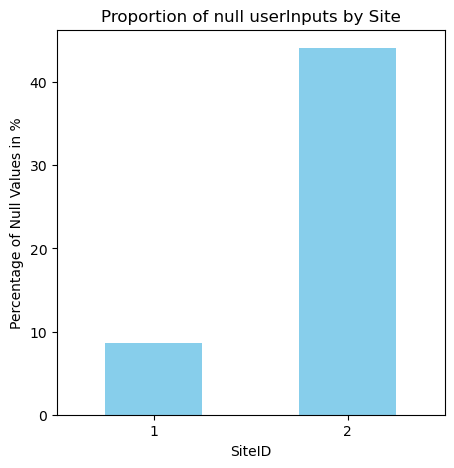

Number of rows for Site 1: 35042
Number of rows for Site 2: 31408


In [153]:
null_proportion = charging.groupby('siteID')['userInputs_kWhRequested'].apply(lambda x: x.isnull().mean() * 100)

# show visually how many percent of each site gave null values
null_proportion.plot(kind='bar', color='skyblue', figsize=(5, 5))
plt.title('Proportion of null userInputs by Site')
plt.ylabel('Percentage of Null Values in %')
plt.xlabel('SiteID')
plt.xticks(rotation=0)
plt.show()


print(f"Number of rows for Site 1: {charging[charging['siteID'] == 1].shape[0]}")
print(f"Number of rows for Site 2: {charging[charging['siteID'] == 2].shape[0]}")


In [154]:
print(f"Total kWhDelivered (null userInputs): {charging.loc[charging['userInputs_kWhRequested'].isnull(), 'kWhDelivered'].sum():.2f}")
print(f"Total kWhDelivered (not null userInputs): {charging.loc[charging['userInputs_kWhRequested'].notnull(), 'kWhDelivered'].sum():.2f}")

Total kWhDelivered (null userInputs): 173901.26
Total kWhDelivered (not null userInputs): 609405.78


This shows that site 1 produces less kwh than site 2 -> indication that site 2, might be public because everyone has access to it?

In [155]:
charging_copy = charging.copy()


charging.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,userInputs_WhPerMile,userInputs_kWhRequested,userInputs_milesRequested,userInputs_minutesAvailable,userInputs_modifiedAt,userInputs_paymentRequired,userInputs_requestedDeparture,connectionDay,disconnectionDay,date_matches
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194,250.0,25.0,100.0,463.0,"Thu, 02 Jan 2020 13:09:39 GMT",True,"Thu, 02 Jan 2020 20:51:54 GMT",2020-01-02,2020-01-02,True
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275,280.0,70.0,250.0,595.0,"Thu, 02 Jan 2020 13:37:11 GMT",True,"Thu, 02 Jan 2020 23:31:50 GMT",2020-01-02,2020-01-02,True
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344,400.0,8.0,20.0,60.0,"Thu, 02 Jan 2020 13:57:17 GMT",True,"Thu, 02 Jan 2020 14:56:35 GMT",2020-01-02,2020-01-03,False
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:03 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",2020-01-02,2020-01-02,True
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334,400.0,8.0,20.0,65.0,"Thu, 02 Jan 2020 14:00:19 GMT",True,"Thu, 02 Jan 2020 15:04:58 GMT",2020-01-02,2020-01-02,True


In [156]:
charging_copy = charging.copy()

# Select columns that start with 'userInputs_'
user_inputs_columns = charging.filter(regex='^userInputs_')

# Find rows with null values in the userInputs_ columns
null_rows = charging[user_inputs_columns.isnull().any(axis=1)]

# Print the first 5 rows with null values
print("First 5 rows with null values in userInputs columns:")
null_rows.head()


First 5 rows with null values in userInputs columns:


,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,userInputs_WhPerMile,userInputs_kWhRequested,userInputs_milesRequested,userInputs_minutesAvailable,userInputs_modifiedAt,userInputs_paymentRequired,userInputs_requestedDeparture,connectionDay,disconnectionDay,date_matches
12,5e23b149f9af8b5fe4b973db,2020-01-02 15:04:38+00:00,2020-01-02 22:08:39+00:00,2020-01-02 22:09:36+00:00,25.567,1_1_178_824_2020-01-02 15:04:38.051735,1,AG-1F07,1-1-178-824,528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-02,2020-01-02,True
49,5e23b149f9af8b5fe4b97400,2020-01-02 19:08:34+00:00,2020-01-02 22:52:36+00:00,2020-01-02 22:53:36+00:00,22.839,1_1_191_811_2020-01-02 19:08:34.209436,1,AG-4F42,1-1-191-811,1283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-02,2020-01-02,True
233,5e2a48e8f9af8b75aed8e976,2020-01-08 05:15:52+00:00,2020-01-08 06:41:58+00:00,2020-01-08 06:42:54+00:00,7.672,1_1_178_817_2020-01-08 05:15:52.086014,1,AG-1F09,1-1-178-817,3687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-08,2020-01-08,True
246,5e2b9a62f9af8b7d745b130a,2020-01-08 13:59:46+00:00,2020-01-09 00:05:39+00:00,2020-01-08 16:41:49+00:00,6.680,1_1_193_816_2020-01-08 13:59:46.501222,1,AG-1F05,1-1-193-816,344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-08,2020-01-09,False
334,5e2cebedf9af8b027e9a5850,2020-01-09 14:45:15+00:00,2020-01-09 19:33:20+00:00,2020-01-09 15:57:23+00:00,6.437,1_1_179_788_2020-01-09 14:45:15.401289,1,AG-3F22,1-1-179-788,576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-09,2020-01-09,True


In [157]:
for column in user_inputs_columns.columns:
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(charging_copy[column]):
        mean_value = charging_copy[column].mean(skipna=True)  # Calculate mean of non-null values
        charging_copy[column].fillna(mean_value, inplace=True)  # Replace nulls with mean


C:\Users\luan0\AppData\Local\Temp\ipykernel_14768\3857152389.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  charging_copy[column].fillna(mean_value, inplace=True)  # Replace nulls with mean


In [158]:
print(charging_copy.isnull().sum())

id                                   0
connectionTime                       0
disconnectTime                       0
doneChargingTime                     0
kWhDelivered                         0
sessionID                            0
siteID                               0
spaceID                              0
stationID                            0
userID                               0
userInputs_WhPerMile                 0
userInputs_kWhRequested              0
userInputs_milesRequested            0
userInputs_minutesAvailable          0
userInputs_modifiedAt            16867
userInputs_paymentRequired       16867
userInputs_requestedDeparture    16867
connectionDay                        0
disconnectionDay                     0
date_matches                         0
dtype: int64


Now all numeric varaibles are replaced with the mean of their respective column. The last null rows are the modifiedAt, requestedDeparture and paymentrequired(boolean).

As we see below, there isn't a single row in the column "paymentRequired" which has the value "False". This could maybe mean that the rows with paymentRequired are registered users while the one in which it is null are unregistered users

In [159]:
true_count = (charging_copy['userInputs_paymentRequired'] == True).sum()

print(f"Number of True values in 'userInputs_paymentRequired': {true_count}")

false_count = (charging_copy['userInputs_paymentRequired'] == False).sum()

print(f"Number of False values in 'userInputs_paymentRequired': {false_count}")



Number of True values in 'userInputs_paymentRequired': 49583
Number of False values in 'userInputs_paymentRequired': 0


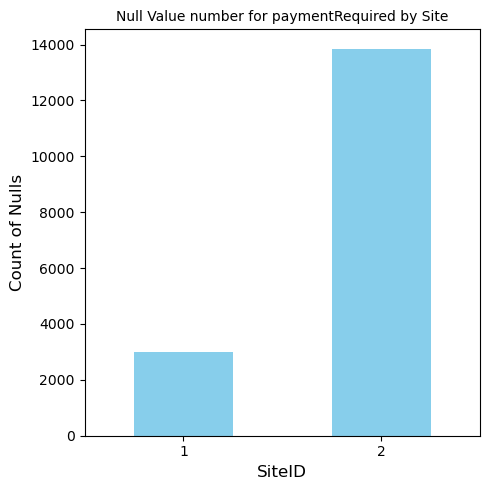

In [160]:
#plot number of nul values in paymentRequried for each site

null_counts_per_site = charging.groupby('siteID')["userInputs_paymentRequired"].apply(lambda x: x.isnull().sum())


null_counts_per_site.plot(kind='bar', color='skyblue', figsize=(5, 5))

plt.title('Null Value number for paymentRequired by Site', fontsize=10)
plt.ylabel('Count of Nulls', fontsize=12)
plt.xlabel('SiteID', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


In [161]:
charging.to_csv('modified_data.csv', index=False)